In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

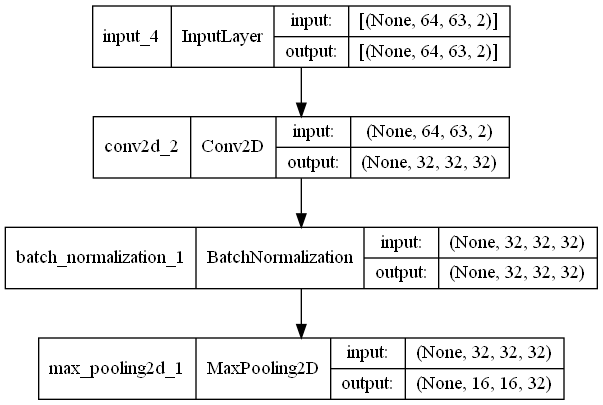

In [7]:
# def model(input_shape, output_shape, growth_rate, config, initial_feature):
initial_feature=32
inputs = keras.Input(shape = (64, 63, 2))
initial_conv = keras.layers.Conv2D(initial_feature, kernel_size=(7,7), strides=2, padding='same', use_bias=False)(inputs)
initial_norm = keras.layers.BatchNormalization()(initial_conv)
initial_pool = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(initial_norm)
model = keras.Model(inputs=inputs, outputs=initial_pool)
keras.utils.plot_model(model, "coded_model.png", show_shapes=True)